In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

In [43]:
solar_power = pd.read_csv('PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0':'timestamp'}).set_index('timestamp')

In [44]:
train_set = solar_power[:'2018-10-31']
valid_set = solar_power['2018-11-01':'2019-11-18']
print('Proportion of train_set : {:.2f}%'.format(len(train_set)/len(solar_power)))
print('Proportion of valid_set : {:.2f}%'.format(len(valid_set)/len(solar_power)))
print(type(train_set))

Proportion of train_set : 0.87%
Proportion of valid_set : 0.13%
<class 'pandas.core.frame.DataFrame'>


In [45]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train_set.Elec_kW.values,n_steps)
valid_x,valid_y = split_sequence(valid_set.Elec_kW.values,n_steps)
print(type(train_x))

<class 'numpy.ndarray'>


In [46]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = torch.from_numpy(feature.astype(np.float32))
        self.target = torch.from_numpy(target.astype(np.float32))

    def __len__(self):
        return len(self.feature)

    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]

        return item,label

In [47]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(3,64,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64*2,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [49]:
train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
train_loader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False)
valid_loader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False)

In [52]:
train_losses = []
valid_losses = []
def Train():

    running_loss = .0

    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())

    print(f'train_loss {train_loss}')

def Valid():
    running_loss = .0

    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss

        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().numpy())
        print(f'valid_loss {valid_loss}')


In [ ]:
epochs = 25
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()


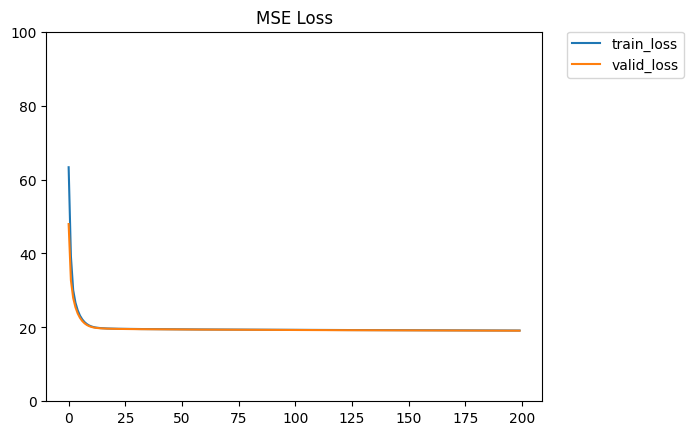

In [54]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [55]:
target_x , target_y = split_sequence(train_set.Elec_kW.values,n_steps)
inputs = target_x.reshape(target_x.shape[0],target_x.shape[1],1)

In [57]:
model.eval()
prediction = []
batch_size = 2
iterations =  int(inputs.shape[0]/2)

for i in range(iterations):
    preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float().to(device))
    prediction.append(preds.detach().cpu().numpy())

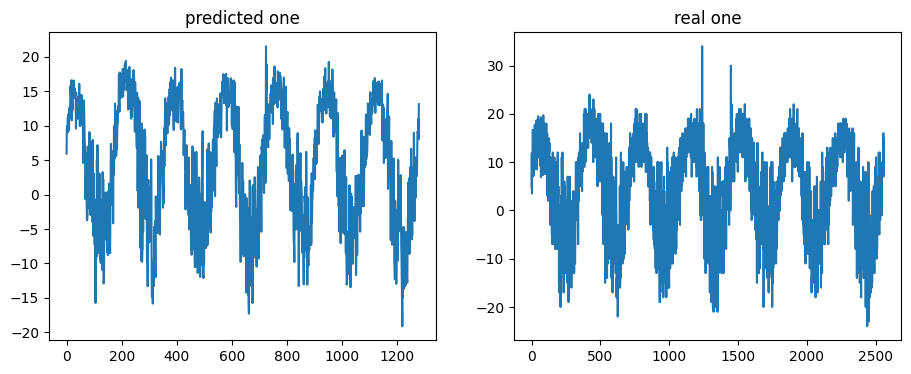

In [58]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(target_y)
plt.show()